In [46]:
import numpy as np
import pandas as pd
import matplotlib as mtl
import matplotlib.pyplot as plt

# Declaración de  clases

In [47]:
#Varilla
#Utilizando Pandas crearemos in  Dataframe con las propiedades de cada varilla según la norma NTC-CONCRETO 1.5.2 NMX-B-457-2013
data = np.array([[9.5,71,29.8,0.56],
                 [12.7,127,39.9,0.994],
                 [15.9,198,50,1.552],
                 [19,285,60,2.235],
                 [22.2,388,69.7,3.042],
                 [25.4,507,79.8,3.973],
                 [28.6,642,89.8,5.033],
                 [31.8,794,99.9,6.225],
                 [34.9,957,109.8,7.503],
                 [38.1,1140,119.7,8.938],
                 [44.5,1552,139.6,12.147],
                 [50.8,2026,159.6,15.890],
                 [57.2,2565,179.5,20.079]])

index = np.array([3,4,5,6,7,8,9,10,11,12,14,16,18])

columns =['Diámetro(mm)','Área(mm2)','Perímetro(mm)','Masa(kg/m)']

listado_varilla = pd.DataFrame(data=data,index=index,columns=columns)

#Definiremos 2 clases; concreto armado, y Columna que  será una clase heredara de concreto armado. 

class ConcretoArmado:
    
    def __init__(self,resistencia_concreto,numero_varilla):
        
        #Concreto
        if resistencia_concreto < 250:
            
            print("NTC-CONCRETO 1.5.1.2 f'c >= 250 kg/cm2")
            self.resistencia_concreto = resistencia_concreto
            
        else:

            self.resistencia_concreto = resistencia_concreto

        self.resistencia_diseño_concreto = 0.8 * self.resistencia_concreto #NTC-CONCRETO 1.5.1.2

        self.modulo_elasticidad_concreto = 14000 * np.sqrt(np.array(self.resistencia_concreto)) #NTC-CONCRETO 1.5.1.4
    
        if self.resistencia_diseño_concreto <= 280: #NTC-CONCRETO 2.1
            
            self.beta_uno = 0.85
        
        else:
            
            b1 = 1.05 - (self.resistencia_diseño_concreto/1400)
            
            if b1 >= 0.65:
                
                self.beta_uno = b1
            else:
                
                self.beta_uno = 0.65
            
            
        
        self.norma_varilla = 'NTC-CONCRETO 1.5.2 NMX-B-457-2013'

        self.numero_varilla = numero_varilla
        
        self.diametro_varilla = listado_varilla.loc[numero_varilla,'Diámetro(mm)'] / 10

        self.area_varilla_cm2 = listado_varilla.loc[numero_varilla,'Área(mm2)'] / 10**2

        self.perimetro_varilla_cm = listado_varilla.loc[numero_varilla,'Perímetro(mm)'] /10

        self.masa_varilla_metro = listado_varilla.loc[numero_varilla,'Masa(kg/m)']

        self.modulo_elasticidad_varilla = 2 * (10**6) #NTC-CONCRETO 1.5.2



class Columna(ConcretoArmado):


    def __init__(self,lado_debil,lado_fuerte,numero_varilla,cantidad_varillas,resistencia_concreto,marco_ductil,altura_libre,Pu,recubrimiento_libre):
        
        super().__init__(resistencia_concreto,numero_varilla)
        
        self.lado_debil = lado_debil

        self.lado_fuerte = lado_fuerte
        
        self.area_bruta_seccion = self.lado_fuerte * self.lado_debil

        self.cantidad_varillas = cantidad_varillas
        
        self.area_acero = self.cantidad_varillas * self.area_varilla_cm2

        self.marco_ductil = bool(marco_ductil)

        self.altura_libre = altura_libre
            
        self.cuantia = self.area_acero / self.area_bruta_seccion
        
        self.cuantia_min = 0.01 if self.marco_ductil else 20 / 4200  #Calculamos el refuerzo máximo y mínimo NTC-CONCRETO 6.2.2

        self.cuantia_max = 0.04 if self.marco_ductil else 0.06 #Calculamos el refuerzo máximo y mínimo NTC-CONCRETO 6.2.2
        
        self.recubrimiento_libre = recubrimiento_libre
        
        self.recubrimiento_dc = (self.diametro_varilla / 2) + self.recubrimiento_libre #NTC-CONCRETO d'c
        
        self.peralte_efectivo = self.lado_fuerte - self.recubrimiento_dc
        
        self.dprima = self.recubrimiento_dc
        
        self.Pu = Pu
        
       

#Requisitos geometricos NTC-CONCRETO 6.2.1 y 7.3.1 
#Utilizaremos metodos de clase para revisar si los datos introducidos por el usuario cumple con las NTC-CONCRETO

    def revision_seccion(self):

        b = self.Pu / (0.5 * self.resistencia_concreto)

        c = self.lado_debil / self.lado_fuerte

        d = self.altura_libre / self.lado_debil

        e = self.lado_fuerte / self.lado_debil

        if self.marco_ductil: #7.3.1
            
            if lado_debil < 30 or self.area_bruta_seccion <  b or c < 0.4 or d > 15 and self.lado_fuerte > self.lado_debil:                

                print('No se cumplen alguno de los Requisitos expuestos en la NTC-CONCRETO 7.3.1 a)\n{0} > 30cm\nb){1} > {2}\nc){3} > 0.4\nd){4} < 15'.format(self.lado_debil,self.area_bruta_seccion,b,c,d))

            
        elif e > 4 or lado_debil < 20:

            print('NTC-CONCRETO 6.2.1 La dimensión mínima no será menor que 20cm, ni la relacion entre dimensión transversal mayor y menor mayor que 4\n\nIntroduzca nuevamente la dimensión menor')

            print('NTC-CONCRETO 6.2.1 La dimensión mínima no será menor que 20cm, ni la relacion entre dimensión transversal mayor y menor mayor que 4\n\nIntroduzca nuevamente la dimensión mayor')

#Calculamos el recubrimiento de la columnas segun la NTC-CONCRETO 4.9.2
        elif recubrimiento_libre < 2:
            
            print('NTC-CONCRETO 4.9.2 Recubrimiento libre debe ser mayor que 2cm')
            
        else:
            return True


#Revision NTC-CONCRETO 6.2.2
    def revision_acero(self):

        if self.cantidad_varillas < 4:
            
            print('NTC-CONCRETO 6.2.2 Para columnas rectangulares la cantidad de varillas mínimas es 4.\n\nCambiar cantidad de varilla\n\n')

        elif self.cuantia < self.cuantia_min and self.marco_ductil == False:

            print('NTC-CONCRETO 6.2.2 No cumple con la cuantia Mínima de acero.\n\nCambiar cantidad de varilla o número de varilla o aumentar la seccion\n\n')


        elif self.cuantia > self.cuantia_max and self.marco_ductil == False:

            print('NTC-CONCRETO 6.2.2 No cumple con la cuantia máxima de acero.\n\nCambiar cantidad de varilla o número de varilla o aumentar la seccion\n\n')

        elif self.marco_ductil: #NTC-CONCRETO 7.3.3

            if self.cuantia < 0.01:

                print('NTC-CONCRETO 7.3.3 No cumple con la cuantia Mínima de acero.\n\nCambiar cantidad de varilla o número de varilla o aumentar la seccion\n\n')

            elif self.cuantia > 0.04:

                print('NTC-CONCRETO 7.3.3 No cumple con la cuantia máxima de acero.\n\nCambiar cantidad de varilla o número de varilla o aumentar la seccion\n\n')

            else:
                pass
        else:
            return True
        


# Cálculo de puntos para el diagrama de interaccion

In [48]:
def resistencia_compresion(columna):
    #P0
    po = (0.85 * columna.resistencia_diseño_concreto * columna.area_bruta_seccion) + (columna.area_acero * 4200) 
    
    return {'pn':po,'mn':0}

def calculo_eje_neutro(columna,lechos,def_uni_acero):
    
    def_uni_concreto = 0.003 #NTC-CONCRETO 2.1
    def_uni_acero = def_uni_acero 
    
    #data framde de los lechos
    lechos_df = pd.DataFrame(lechos)
    
    #Calculamos area de acero
    area_nominal = listado_varilla.loc[lechos_df['numero'],'Área(mm2)'].values
    lechos_df['As'] = area_nominal * lechos_df.cantidad.values / (10 ** 2)
    
    #eje neutro
    c = (def_uni_concreto * columna.peralte_efectivo) / (def_uni_concreto + def_uni_acero)
    
    
    #Revisamos que lechos quedaron en la zona de compresión
    
    lechos_df['compresion'] = lechos_df.profundidad < c
    
    
    #calculo de la deformacion de lechos de refuerzo
    
    acero_compresion = lambda: def_uni_concreto * (c - lechos_df.profundidad) / c
    acero_tension = lambda: def_uni_acero * (lechos_df.profundidad - c) / (columna.peralte_efectivo - c)
    
    lechos_df['def_uni'] = 0
    lechos_df['def_uni'] = np.where(lechos_df['profundidad'] <= c,acero_compresion(),acero_tension())
    
    
    #calculo de los efuerzos en el acero a compresion
    lechos_df['esfuerzo'] = 0
    lechos_df['esfuerzo'] = np.where(lechos_df['def_uni'] >= 0.002,4200,lechos_df.def_uni*(columna.modulo_elasticidad_varilla))
    
    
    #Calcula de la fuerza producida por cada lecho
    
    fuerzas_positivas = lambda:lechos_df.As.values * lechos_df.esfuerzo.values
    fuerzas_negativas = lambda: -1 * lechos_df.As.values * lechos_df.esfuerzo.values
    
    lechos_df['fuerza'] = np.where(lechos_df.compresion != True,fuerzas_negativas(),fuerzas_positivas())
    
    #calculo de la fuerza producida por el bloque de esfuerzon a compresión del concreto
    
    p_concreto = 0.85 * columna.resistencia_diseño_concreto * columna.beta_uno * c * columna.lado_debil
    
    palanca_concreto = (0.5 * columna.lado_fuerte) - ((columna.beta_uno * c) / 2)
    
    momento_concreto = p_concreto * palanca_concreto
    
    #cacular brazo de palanca de cada lecho
    
    brazos_compresion = lambda: np.absolute((0.5 * columna.lado_fuerte) - lechos_df.profundidad) 
    brazos_tension = lambda: np.absolute(lechos_df.profundidad - (0.5 * columna.lado_fuerte))
    
    lechos_df['brazo'] = np.where(lechos_df.compresion,brazos_compresion(),brazos_tension())
    lechos_df['momento'] = np.absolute(lechos_df.fuerza.values) * lechos_df.brazo.values
    
    momento = lechos_df['momento'].sum() + momento_concreto
    carga = lechos_df['fuerza'].sum() + p_concreto
    eje_neutro = c
    
    #Area de acero a tensión
    as_compresion = lechos_df[lechos_df.compresion].As.sum()
    as_tension = lechos_df[lechos_df.compresion != True ].As.sum()
    
    return {'eje_neutro':eje_neutro, 'pn':carga, 'mn':momento, 'as_compresion':as_compresion, 'as_tension':as_tension,"lechos":lechos_df,'p_concreto':p_concreto,' momento_concreto': momento_concreto}
   
    
def flexion_pura(columna,dictionary):
    #NTC-CONCRETO 2.2.4
    as_compresion = dictionary['as_compresion']
    as_tension = dictionary['as_tension']

    cuantia_compresion = as_compresion / (columna.lado_debil * columna.peralte_efectivo)
    
    cuantia_tension = as_tension / (columna.lado_debil * columna.peralte_efectivo)
    
    a = cuantia_tension - cuantia_compresion
    
    b = ((6000 * columna.beta_uno) / (6000 - 4200)) * (columna.dprima / columna.peralte_efectivo) * (0.85 * columna.resistencia_diseño_concreto / 4200)
    
    if a >= b:
        
        
        alpha = ((as_tension - as_compresion) * 4200) / (0.85 * columna.resistencia_diseño_concreto * columna.lado_debil) 
        
        x = (as_tension - as_compresion) * 4200
        
        y = columna.peralte_efectivo - (alpha / 2)
        
        z = as_compresion * 4200 * (columna.peralte_efectivo - columna.dprima)
        
        mr = 1 * ((x * y) + z)
    
    else:
        
        q = (cuantia_tension * 4200) / (0.85 * columna.resistencia_diseño_concreto)
        
        mr = 1 * columna.lado_debil * (columna.peralte_efectivo ** 2) * (0.85 * columna.resistencia_diseño_concreto) * q * ( 1 - (0.5 * q))
        
    return mr


def falla_tension (columna,lechos,dictionary,porcentaje):
     #eje neutro
    c = porcentaje * dictionary['eje_neutro']
    
    
    def_uni_concreto = 0.003 #NTC-CONCRETO 2.1
    #Deformacion unitaria del acero
    def_uni_acero =  def_uni_concreto * ((columna.peralte_efectivo / c) - 1)
    
    
    #data framde de los lechos
    lechos_df = pd.DataFrame(lechos)
    
    #Calculamos area de acero
    area_nominal = listado_varilla.loc[lechos_df['numero'],'Área(mm2)'].values
    lechos_df['As'] = area_nominal * lechos_df.cantidad.values / (10 ** 2)
    
    
    #Revisamos que lechos quedaron en la zona de compresión
    
    lechos_df['compresion'] = lechos_df.profundidad < c
    
    
    #calculo de la deformacion de los de refuerzo
    
    acero_compresion = lambda: def_uni_concreto * (c - lechos_df.profundidad) / c
    acero_tension = lambda: def_uni_acero * (lechos_df.profundidad - c) / (columna.peralte_efectivo - c)
    
    lechos_df['def_uni'] = 0
    lechos_df['def_uni'] = np.where(lechos_df['profundidad'] <= c,acero_compresion(),acero_tension())
    
    
    #calculo de los efuerzos en el acero a compresion
    lechos_df['esfuerzo'] = 0
    lechos_df['esfuerzo'] = np.where(lechos_df['def_uni'] >0.002,4200,lechos_df.def_uni*(columna.modulo_elasticidad_varilla))
    
    
    #Calcula de la fuerza producida por cada lecho
    
    fuerzas_positivas = lambda:lechos_df.As.values * lechos_df.esfuerzo.values
    fuerzas_negativas = lambda: -1 * lechos_df.As.values * lechos_df.esfuerzo.values
    
    lechos_df['fuerza'] = np.where(lechos_df.compresion != True,fuerzas_negativas(),fuerzas_positivas())
    
    #calculo de la fuerza producida por el bloque de esfuerzon a compresión del concreto
    
    p_concreto = 0.85 * columna.resistencia_diseño_concreto * columna.beta_uno * c * columna.lado_debil
    
    palanca_concreto = (0.5 * columna.lado_fuerte) - ((columna.beta_uno * c) / 2)
    
    momento_concreto = p_concreto * palanca_concreto
    
    #cacular brazo de palanca de cada lecho
    
    brazos_compresion = lambda: np.absolute((0.5 * columna.lado_fuerte) - lechos_df.profundidad) 
    brazos_tension = lambda: np.absolute(lechos_df.profundidad - (0.5 * columna.lado_fuerte))
    
    lechos_df['brazo'] = np.where(lechos_df.compresion,brazos_compresion(),brazos_tension())
    lechos_df['momento'] = np.absolute(lechos_df.fuerza.values) * lechos_df.brazo.values
    
    momento = lechos_df['momento'].sum() + momento_concreto
    carga = lechos_df['fuerza'].sum() + p_concreto
    eje_neutro = c
    
    #Area de acero a tensión
    as_compresion = lechos_df[lechos_df.compresion].As.sum()
    as_tension = lechos_df[lechos_df.compresion != True ].As.sum()
    
    return {'eje_neutro':eje_neutro, 'pn':carga, 'mn':momento, 'as_compresion':as_compresion, 'as_tension':as_tension,"lechos":lechos_df,'p_concreto':p_concreto,' momento_concreto': momento_concreto}
    
    
#Calculo de la resistencia de diseño
def crear_punto(e):
    
    return {'pn':100,'mn':100*e}


def ecuacion_recta(punto,punto2):
    
    pendiente = (punto2['pn'] - punto['pn']) / (punto2['mn'] - punto['mn'])
    
    b = punto['pn'] - (pendiente * punto['mn'])
    
    #En la zona de falla por flexión e_min > e_max
    
    e_min = punto['mn'] / punto['pn'] if punto['pn'] != 0 else False 
    
    e_max = punto2['mn'] / punto2['pn'] if punto2['pn'] != 0 else False 
    
    
    
    return {'m':pendiente,'b':b,'e_min':e_min,'e_max':e_max}

def interseccion(recta,recta2):
    
    x = (recta2['b'] - recta['b']) / (recta['m'] - recta2['m'])
    y = recta2['m'] * x + recta2['b']
    return{'x':x,'y':y}

def resistencia_biaxial(resitencia,resistacia2, Po):
    prx = resistencia['y']
    pry = resistencia2['y']
    pro = Po['pn']
    
    a = 1/(prx * 0.8)
    b = 1/(pry * 0.8)
    c = 1/(pro * 0.8)
    
    prn = 1/ (a + b - c)
    
    if prn/pro >= 0.1:
        return  {'prn':prn/1000,'mensaje': "Prn/Po >= 0.1 NTC 2.3.2"}

# Introducción de valores de la columna

In [98]:
#lado sobre eje x en cm 
lado_debil = 30

#lado sobre eje y en cm
lado_fuerte = 50

#numero del diámetro de la varilla
numero_varilla = 8 

#toda la seccion
cantidad_varillas = 10

#kg/cm2
resistencia_concreto = 200

#True o False
marco_ductil = False

#cm
altura_libre = 400

#Carga ultima kg NTC-CONCRETO 2.3.2
Pu = 140000

#recubrimiento en cm
recubrimiento_libre = 2.5

#excentricidad de diseño en cm
#e = excentricidad para el momento aplicado en x
#e2 = exventricidad para el momento aplicado en y

e = 30
e2 = 20


#Nombre del archivo
name = 'MomentoMx'
name2='MomentoMy'


In [99]:
#No mover
#Mx
columna = Columna(lado_debil,lado_fuerte,numero_varilla,cantidad_varillas,resistencia_concreto,marco_ductil,altura_libre,Pu,recubrimiento_libre)

#My
columna2 = Columna(lado_fuerte,lado_debil,numero_varilla,cantidad_varillas,resistencia_concreto,marco_ductil,altura_libre,Pu,recubrimiento_libre)


NTC-CONCRETO 1.5.1.2 f'c >= 250 kg/cm2
NTC-CONCRETO 1.5.1.2 f'c >= 250 kg/cm2


# Lechos de Refuerzo

In [100]:
#Lechos de Refuerzo

''''
En caso de que la sección tenga más lechos solo agregarlo con el siguiente formato
en la parte de abajo

La profundidad del primer lecho siempre es columna.dprima para el momento Mx
y columna2.dprima para el momento My el del último lecho será
columna.peralte_efectivo

lechoN = {
    "numero":,
    "cantidad":,
    "profundidad":
    }
    
y agregar en el nombre en la lista:
==>Para momento alrededor del eje x

lechos =[lecho1,lecho2,lecho3....,lechoN]

==> Para momento alrededor del eje y

lechos2 =[lechoy1,lechoy2,lechoy3....,lechoyN]

'''
# Para el momento alredodor del eje x
lecho1 = {
    "numero":8,
    "cantidad":4,
    "profundidad":columna.dprima
    }

lecho2 = {
    "numero":8,
    "cantidad":2,
    "profundidad":20 + columna.dprima
    }

lecho3 = {
    "numero":8,
    "cantidad":4,
    "profundidad":columna.peralte_efectivo
    }





lechos = [lecho1,lecho2,lecho3]

#Para el momento alrededor de eje y

lechoy1 = {
    "numero":8,
    "cantidad":3,
    "profundidad":columna2.dprima
    }

lechoy2 = {
    "numero":8,
    "cantidad":2,
    "profundidad":8 + columna2.dprima
    }

lechoy3 = {
    "numero":8,
    "cantidad":2,
    "profundidad":16 + columna2.dprima
    }

lechoy4 = {
    "numero":8,
    "cantidad":3,
    "profundidad": columna2.peralte_efectivo
    }

lechos2 = [lechoy1,lechoy2,lechoy3,lechoy4]


# Revisión de la sección transversal

In [101]:
print('Momento eje X:{0}\nMomento eje Y {1}'.format(columna.revision_seccion(),columna2.revision_seccion()))

Momento eje X:True
Momento eje Y True


# Revisión de las cuantias de acero

In [102]:
print('Momento eje X:{0}\nMomento eje Y {1}'.format(columna.revision_acero(),columna2.revision_acero()))

Momento eje X:True
Momento eje Y True


# Cálculo de los puntos del diagrama
## Resistencia a compresión

In [103]:
Po = resistencia_compresion(columna)
Po2 = resistencia_compresion(columna2) 
print("La resistencia a la compresión simple es {0:,.2f}kg".format(Po['pn']))

La resistencia a la compresión simple es 416,940.00kg


## Falla Balanceada

In [104]:
def_uni_acero = 0.002 #NTC-CONCRETO 2.1

falla_balanceada = calculo_eje_neutro(columna,lechos,def_uni_acero)
falla_balanceada2 = calculo_eje_neutro(columna2,lechos2,def_uni_acero)
   

## Resistencia a la flexión 

In [105]:
mr = flexion_pura(columna,falla_balanceada)
mr2 = flexion_pura(columna2,falla_balanceada2)

Mo = {'pn':0,'mn':mr}
Mo2 = {'pn':0,'mn':mr2}


## Puntos entre Po y falla balanceada

In [106]:
#Para momento Mx
punto4 = calculo_eje_neutro(columna,lechos,0)
punto3 = calculo_eje_neutro(columna,lechos,0.001)
punto2 = calculo_eje_neutro(columna,lechos,0.00125)
punto1 = calculo_eje_neutro(columna,lechos,0.0015)   


#Para momento My
punto2_4 = calculo_eje_neutro(columna2,lechos2,0)
punto2_3 = calculo_eje_neutro(columna2,lechos2,0.001)
punto2_2 = calculo_eje_neutro(columna2,lechos2,0.00125)
punto2_1 = calculo_eje_neutro(columna2,lechos2,0.0015)   

## Puntos entre falla Balanceada y M0

In [107]:
#Para momento Mx
punto5 = falla_tension (columna,lechos,falla_balanceada,0.8)
punto6 = falla_tension (columna,lechos,falla_balanceada,0.7)
punto7 = falla_tension (columna,lechos,falla_balanceada,0.6)

abscisa = np.array([Po['mn'],punto4['mn'],punto3['mn'],punto2['mn'],punto1['mn'],falla_balanceada['mn'],punto5['mn'],punto6['mn'],punto7['mn'],mr])
ordenada =np.array([Po['pn'],punto4['pn'],punto3['pn'],punto2['pn'],punto1['pn'],falla_balanceada['pn'],punto5['pn'],punto6['pn'],punto7['pn'],0])

#Para momento My
punto2_5 = falla_tension (columna2,lechos2,falla_balanceada2,0.8)
punto2_6 = falla_tension (columna2,lechos2,falla_balanceada2,0.7)
punto2_7 = falla_tension (columna2,lechos2,falla_balanceada2,0.6)

abscisa2 = np.array([Po2['mn'],punto2_4['mn'],punto2_3['mn'],punto2_2['mn'],punto2_1['mn'],falla_balanceada2['mn'],punto2_5['mn'],punto2_6['mn'],punto2_7['mn'],mr2])
ordenada2 =np.array([Po2['pn'],punto2_4['pn'],punto2_3['pn'],punto2_2['pn'],punto2_1['pn'],falla_balanceada2['pn'],punto2_5['pn'],punto2_6['pn'],punto2_7['pn'],0])


# Código del Gráfico

In [108]:

#Creación de de las rectas Para Diagrama Mx

Po_Punto4 = ecuacion_recta(Po,punto4)
Punto4_Punto3 = ecuacion_recta(punto4,punto3)
Punto3_Punto2 = ecuacion_recta(punto3,punto2)
Punto2_Punto1 = ecuacion_recta(punto2,punto1)
Punto1_FB = ecuacion_recta(punto1,falla_balanceada)
Punto5_FB = ecuacion_recta(punto5,falla_balanceada)
Punto6_Punto5 = ecuacion_recta(punto6,punto5)
Punto7_Punto6 = ecuacion_recta(punto7,punto6)
Mo_Punto7 = ecuacion_recta(Mo,punto7)


#Creación de de las rectas Para Diagrama My

yPo_Punto4 = ecuacion_recta(Po2,punto2_4)
yPunto4_Punto3 = ecuacion_recta(punto2_4,punto2_3)
yPunto3_Punto2 = ecuacion_recta(punto2_3,punto2_2)
yPunto2_Punto1 = ecuacion_recta(punto2_2,punto2_1)
yPunto1_FB = ecuacion_recta(punto2_1,falla_balanceada2)
yPunto5_FB = ecuacion_recta(punto2_5,falla_balanceada2)
yPunto6_Punto5 = ecuacion_recta(punto2_6,punto2_5)
yPunto7_Punto6 = ecuacion_recta(punto2_7,punto2_6)
yMo_Punto7 = ecuacion_recta(Mo2,punto2_7)


#Origen
origen = {'pn':0,'mn':0}
punto = crear_punto(e)
punto2 = crear_punto(e2)

#Ecuación de la recta correspondiente a la excentricidad e
recta_diseño = ecuacion_recta(origen,punto)
recta_diseño2 = ecuacion_recta(origen,punto2)

#Calculo de la resistencia de la seccion para Mx

if e >= Po_Punto4['e_min'] and e < Po_Punto4['e_max']:
    
    resistencia = interseccion(recta_diseño,Po_Punto4)
    
elif e >= Punto4_Punto3['e_min'] and e < Punto4_Punto3['e_max']:
    
    resistencia = interseccion(recta_diseño,Punto4_Punto3)

elif e >= Punto3_Punto2['e_min'] and e < Punto3_Punto2['e_max']:
            
    resistencia = interseccion(recta_diseño,Punto3_Punto2)
            
elif e >= Punto2_Punto1['e_min'] and e < Punto2_Punto1['e_max']:
                    
    resistencia = interseccion(recta_diseño,Punto2_Punto1)
                    
elif e >= Punto1_FB['e_min'] and e < Punto1_FB['e_max']:
                    
    resistencia = interseccion(recta_diseño,Punto1_FB)
                    
elif e >= Punto5_FB['e_max']  and e < Punto5_FB['e_min']:
                            
    resistencia = interseccion(recta_diseño,Punto5_FB)
                        
elif e >= Punto6_Punto5['e_max']  and e < Punto6_Punto5['e_min']:
                                
    resistencia = interseccion(recta_diseño,Punto6_Punto5)
                                
elif e >= Punto7_Punto6['e_max']  and e < Punto7_Punto6['e_min']:
    
    resistencia = interseccion(recta_diseño,Punto7_Punto6)
                                
else:
                                    
    resistencia = interseccion(recta_diseño,Mo_Punto7)
                                

#Calculo de la resistencia de la seccion para My

if e2 >= yPo_Punto4['e_min'] and e2 < yPo_Punto4['e_max']:
    
    resistencia2 = interseccion(recta_diseño2,yPo_Punto4)
    
elif e2 >= yPunto4_Punto3['e_min'] and e2 < yPunto4_Punto3['e_max']:
    
    resistencia2 = interseccion(recta_diseño2,yPunto4_Punto3)

elif e2 >= yPunto3_Punto2['e_min'] and e2 < yPunto3_Punto2['e_max']:
            
    resistencia2 = interseccion(recta_diseño2,yPunto3_Punto2)
            
elif e2 >= yPunto2_Punto1['e_min'] and e2 < yPunto2_Punto1['e_max']:
                    
    resistencia2 = interseccion(recta_diseño2,yPunto2_Punto1)
                    
elif e2 >= yPunto1_FB['e_min'] and e2 < yPunto1_FB['e_max']:
                    
    resistencia2 = interseccion(recta_diseño2,yPunto1_FB)
                    
elif e2 >= yPunto5_FB['e_max']  and e2 < yPunto5_FB['e_min']:
                            
    resistencia2 = interseccion(recta_diseño2,yPunto5_FB)
                        
elif e2 >= yPunto6_Punto5['e_max']  and e2 < yPunto6_Punto5['e_min']:
                                
    resistencia2 = interseccion(recta_diseño2,yPunto6_Punto5)
                                
elif e2 >= yPunto7_Punto6['e_max']  and e2 < yPunto7_Punto6['e_min']:
    
    resistencia2 = interseccion(recta_diseño2,yPunto7_Punto6)
                                
else:
                                    
    resistencia2 = interseccion(recta_diseño2,yMo_Punto7)


In [109]:
recta_diseño

{'b': 0.0, 'e_max': 30.0, 'e_min': False, 'm': 0.03333333333333333}

# Grafico Mx

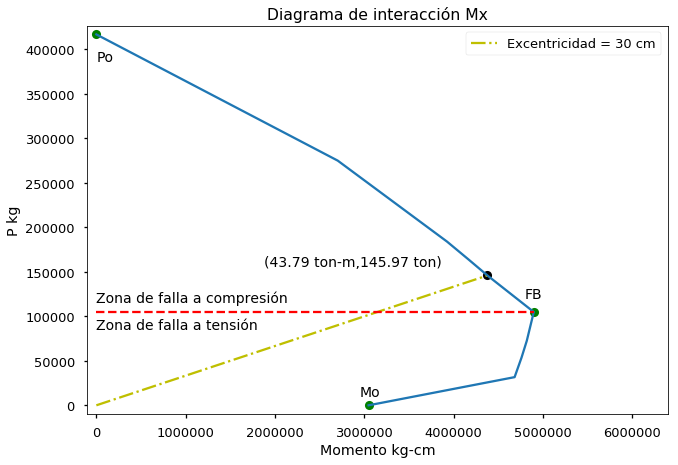

In [110]:
%matplotlib inline

style = dict(size= 14 , color = 'black')
plt.style.use('seaborn-talk')

#Para graficar resistencia de la sección
eje_x = np.linspace(0,resistencia['x'],10)
plt.plot(resistencia['x'],resistencia['y'],'ko')
plt.plot(eje_x,eje_x/e,'y-.',label='Excentricidad = {} cm'.format(e))
plt.text(resistencia['x']-2500000,resistencia['y']+10000,'({0:.2f} ton-m,{1:.2f} ton)'.format(resistencia['x']/(100*1000),(resistencia['y'])/1000),**style)

#Para graficar falla balanceada
h = np.linspace(0,falla_balanceada['mn'],10)
b = np.full((h.shape[0],),falla_balanceada['pn'])

#Puntos del Gáfico interacción
plt.plot(Po['mn'],Po['pn'],'go')
plt.plot(mr,0,'go')
plt.plot(falla_balanceada['mn'],falla_balanceada['pn'],'go')
plt.plot(abscisa,ordenada,'-');
plt.plot(h,b,'r--')
plt.xlim(-100000,falla_balanceada['mn']+1500000)
plt.ylim(-10000,Po['pn'] + 10000);
plt.xlabel('Momento kg-cm')
plt.ylabel('P kg')
plt.text(falla_balanceada['mn']-100000,falla_balanceada['pn']+15000,'FB',**style)
plt.text(0,Po['pn'] - 30000,'Po',**style)
plt.text(0,falla_balanceada['pn'] + 11000,'Zona de falla a compresión',**style)
plt.text(0,falla_balanceada['pn'] - 20000,'Zona de falla a tensión',**style)
plt.text(mr-100000,10000,'Mo',**style)
plt.title('Diagrama de interacción Mx')
plt.legend()
plt.savefig("./{0}".format(name));

# Momento My

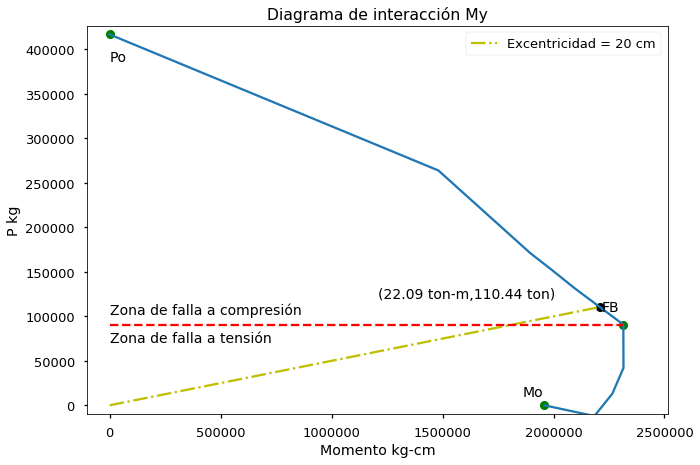

In [111]:
%matplotlib inline

style = dict(size= 14 , color = 'black')
plt.style.use('seaborn-talk')

#Para graficar resistencia de la sección
eje_x = np.linspace(0,resistencia2['x'],10)
plt.plot(resistencia2['x'],resistencia2['y'],'ko')
plt.plot(eje_x,eje_x/e2,'y-.',label='Excentricidad = {} cm'.format(e2))
plt.text(resistencia2['x']-1000000,resistencia2['y']+10000,'({0:.2f} ton-m,{1:.2f} ton)'.format(resistencia2['x']/(100*1000),(resistencia2['y'])/1000),**style)

#Para graficar falla balanceada
h = np.linspace(0,falla_balanceada2['mn'],10)
b = np.full((h.shape[0],),falla_balanceada2['pn'])

#Puntos del Gáfico interacción
plt.plot(Po2['mn'],Po2['pn'],'go')
plt.plot(mr2,0,'go')
plt.plot(falla_balanceada2['mn'],falla_balanceada2['pn'],'go')
plt.plot(abscisa2,ordenada2,'-');
plt.plot(h,b,'r--')
plt.xlim(-100000,falla_balanceada2['mn']+200000)
plt.ylim(-10000,Po2['pn'] + 10000);
plt.xlabel('Momento kg-cm')
plt.ylabel('P kg')
plt.text(falla_balanceada2['mn']-100000,falla_balanceada2['pn']+15000,'FB',**style)
plt.text(0,Po2['pn'] - 30000,'Po',**style)
plt.text(0,falla_balanceada2['pn'] + 11000,'Zona de falla a compresión',**style)
plt.text(0,falla_balanceada2['pn'] - 20000,'Zona de falla a tensión',**style)
plt.text(mr2-100000,10000,'Mo',**style)
plt.title('Diagrama de interacción My')
plt.legend()
plt.savefig("./{0}".format(name2));

## Resistencia a la Flexocompresión en dos direcciones

In [97]:

prn = resistencia_biaxial(resistencia,resistencia2,Po)

print('La resistencia de la columna  es: {0:.2f} ton.\nLa Pr = Prn: {1:.2f} ton.'.format(prn['prn'],prn['prn']),prn['mensaje'])

La resistencia de la columna  es: 65.52 ton.
La Pr = Prn: 65.52 ton. Prn/Po >= 0.1 NTC 2.3.2
